In [25]:
# Imports
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from transform import EntrywiseDropout, DistributedDropout, UniformDropout
from parameter import Parameters, parse_parameters
from dataset import XORMixture
from model import NonlinearModel
import trainer
import utils

# Set print options
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(edgeitems=10000)

In [311]:
PARAMETERS = {
    'd': 128,
    'm': 50,
    'n': 1000,
    'noise_rate': 0.15,
    'lr': 5.0,
    'epochs': 500,
    'p': 0.5,
    'cluster_var': 1/50,           # 1/25*1/d
    'init_var': 1/16*1/(100*10),   # 1/16*1/(md)
    'avg': 25,
    'seed': 0,
    'test_all': False,
    'filename': "out.log",
}

PARAMS = parse_parameters(sys.argv, PARAMETERS)

In [312]:
# utils.set_random_seeds(PARAMS.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [313]:
# PARAMS['cluster_var'] = np.array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) * 2
# PARAMS['cluster_var'] = np.array([0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10])

In [314]:
print(PARAMS)

{'d': 128, 'm': 50, 'n': 1000, 'noise_rate': 0.15, 'lr': 5.0, 'epochs': 500, 'p': 0.5, 'cluster_var': 0.02, 'init_var': 6.25e-05, 'avg': 25, 'seed': 0, 'test_all': False, 'filename': 'out.log'}


In [315]:
dataset = XORMixture(
    dims=PARAMS.d,
    var=PARAMS.cluster_var,
    n=PARAMS.n,
    noise_rate=PARAMS.noise_rate,
)

In [316]:
# Verify covariance values
z = dataset.x[0:250]
z0 = (z - z.mean(axis=0)[np.newaxis, :])
cov_z = (z0.T @ z0) / (z0.shape[0] - 1)
print(torch.diag(cov_z))

tensor([0.0222, 0.0187, 0.0206, 0.0228, 0.0215, 0.0211, 0.0206, 0.0150, 0.0200,
        0.0196, 0.0199, 0.0206, 0.0212, 0.0187, 0.0213, 0.0217, 0.0193, 0.0184,
        0.0185, 0.0194, 0.0202, 0.0208, 0.0195, 0.0191, 0.0215, 0.0192, 0.0184,
        0.0195, 0.0219, 0.0194, 0.0175, 0.0194, 0.0198, 0.0208, 0.0174, 0.0184,
        0.0196, 0.0217, 0.0194, 0.0208, 0.0209, 0.0212, 0.0230, 0.0222, 0.0185,
        0.0197, 0.0180, 0.0198, 0.0179, 0.0191, 0.0226, 0.0199, 0.0201, 0.0186,
        0.0195, 0.0175, 0.0225, 0.0202, 0.0206, 0.0165, 0.0234, 0.0226, 0.0181,
        0.0178, 0.0217, 0.0196, 0.0188, 0.0201, 0.0183, 0.0195, 0.0210, 0.0233,
        0.0210, 0.0211, 0.0213, 0.0210, 0.0193, 0.0209, 0.0167, 0.0219, 0.0183,
        0.0197, 0.0216, 0.0206, 0.0200, 0.0181, 0.0201, 0.0186, 0.0184, 0.0222,
        0.0200, 0.0206, 0.0201, 0.0167, 0.0194, 0.0177, 0.0191, 0.0197, 0.0207,
        0.0193, 0.0209, 0.0197, 0.0216, 0.0178, 0.0176, 0.0191, 0.0186, 0.0169,
        0.0205, 0.0192, 0.0200, 0.0196, 

### Train w/o Dropout

In [317]:
no_aug = []
for i in range(PARAMS.avg):
    dataset._shuffle()
    for params in PARAMS:
        transforms = None
        model = NonlinearModel(
                in_dim=params.d,
                hidden_dim=params.m,
                out_dim=1,
                init_var=params.init_var,
        )
        model.to(device)
        m, h = trainer.train(model, dataset, transforms, params.epochs,
                             params.lr, device, test_all=params.test_all,
                             leave=False)
    no_aug.append(h)

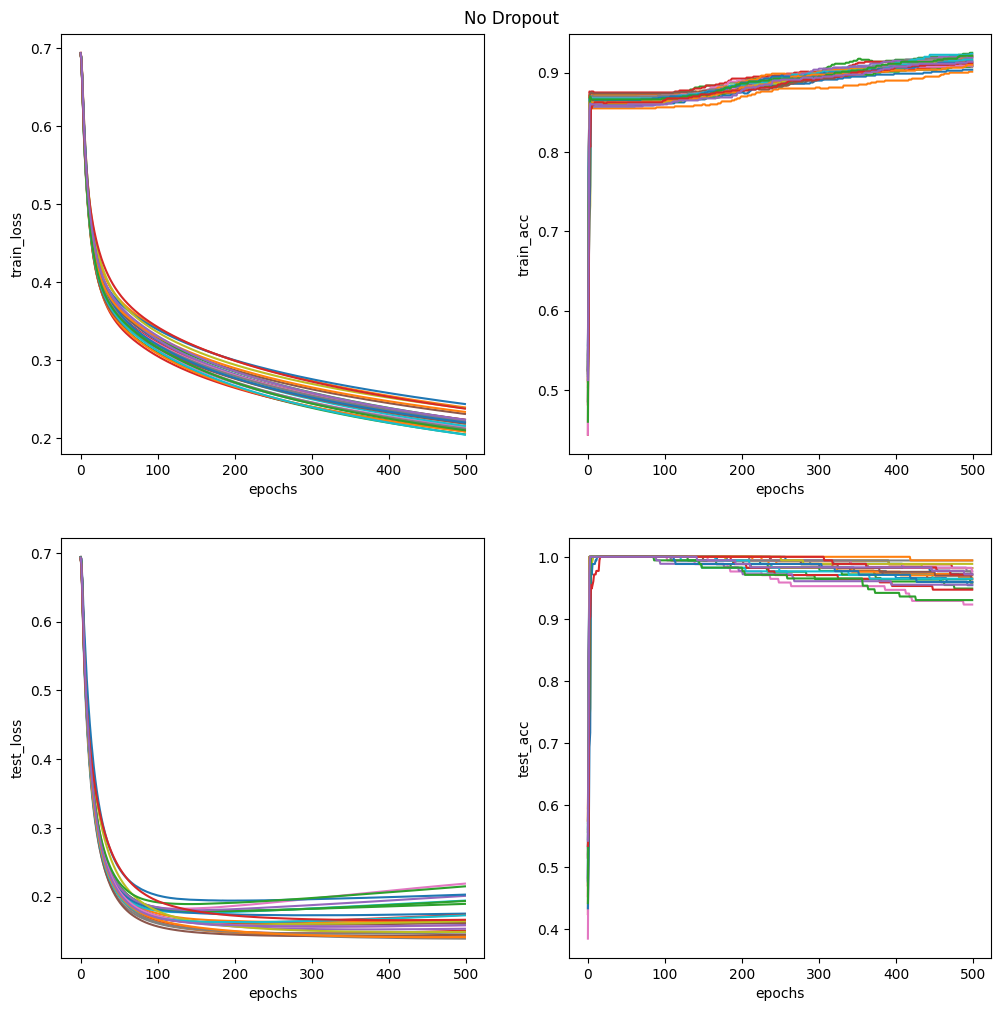

In [318]:
plt.figure(figsize=(12,12))
for j, key in enumerate(no_aug[0].keys()):
    for i in no_aug:
        plt.subplot(2,2,j+1)
        plt.plot(i[key])
        plt.xlabel("epochs")
        plt.ylabel(key)
plt.suptitle("No Dropout", y=0.90)
plt.show()

### Train w/ Constant Dropout

In [319]:
const_aug = {}
for d in np.arange(0, 1.0, 0.1):
    const_aug[d] = []
    for i in range(PARAMS.avg):
        dataset._shuffle()
        for params in PARAMS:
            transforms = nn.Dropout(d)
            model = NonlinearModel(
                    in_dim=params.d,
                    hidden_dim=params.m,
                    out_dim=1,
                    init_var=params.init_var,
            )
            model.to(device)
            m, h = trainer.train(model, dataset, transforms, params.epochs,
                                 params.lr, device, test_all=params.test_all,
                                 leave=False)
        const_aug[d].append(h)

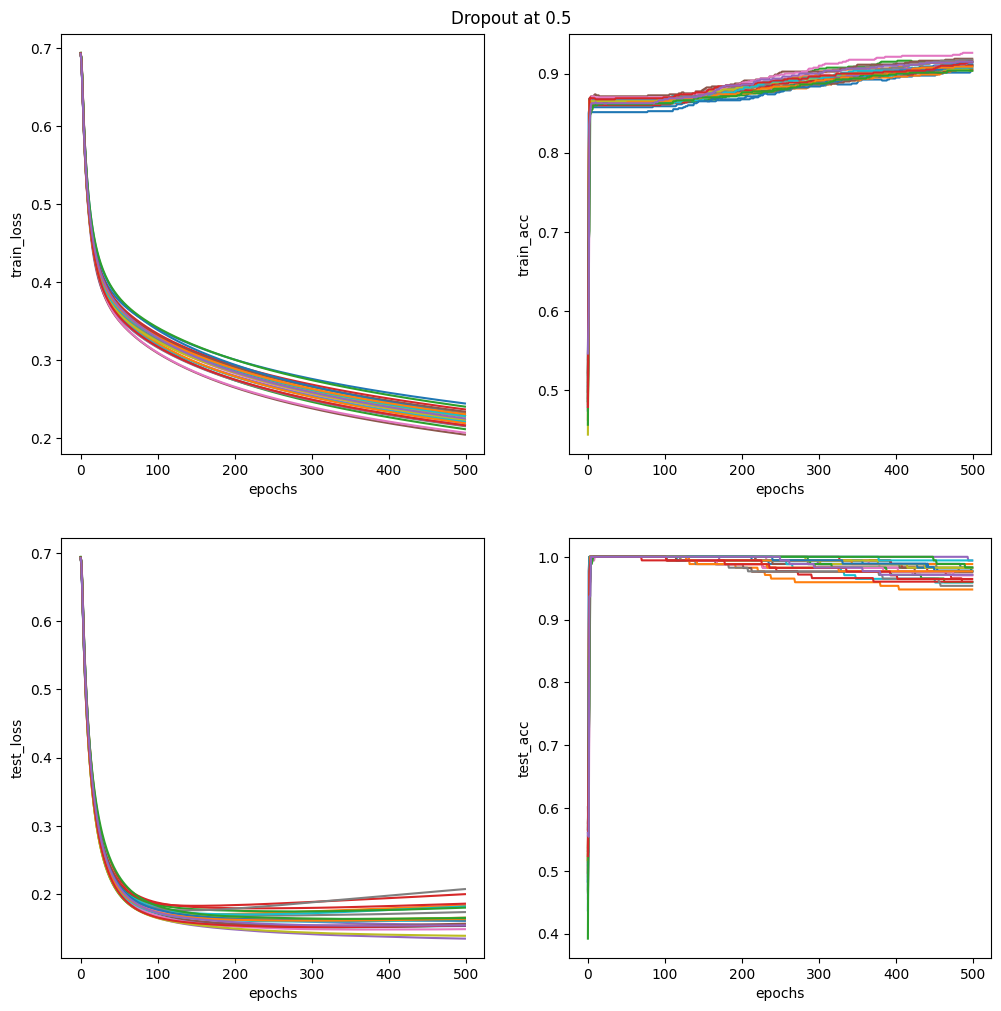

In [320]:
plt.figure(figsize=(12,12))
for j, key in enumerate(const_aug[0.0][0].keys()):
    for i in const_aug[0]:
        plt.subplot(2,2,j+1)
        plt.plot(i[key])
        plt.xlabel("epochs")
        plt.ylabel(key)
plt.suptitle("Dropout at 0.5", y=0.90)
plt.show()

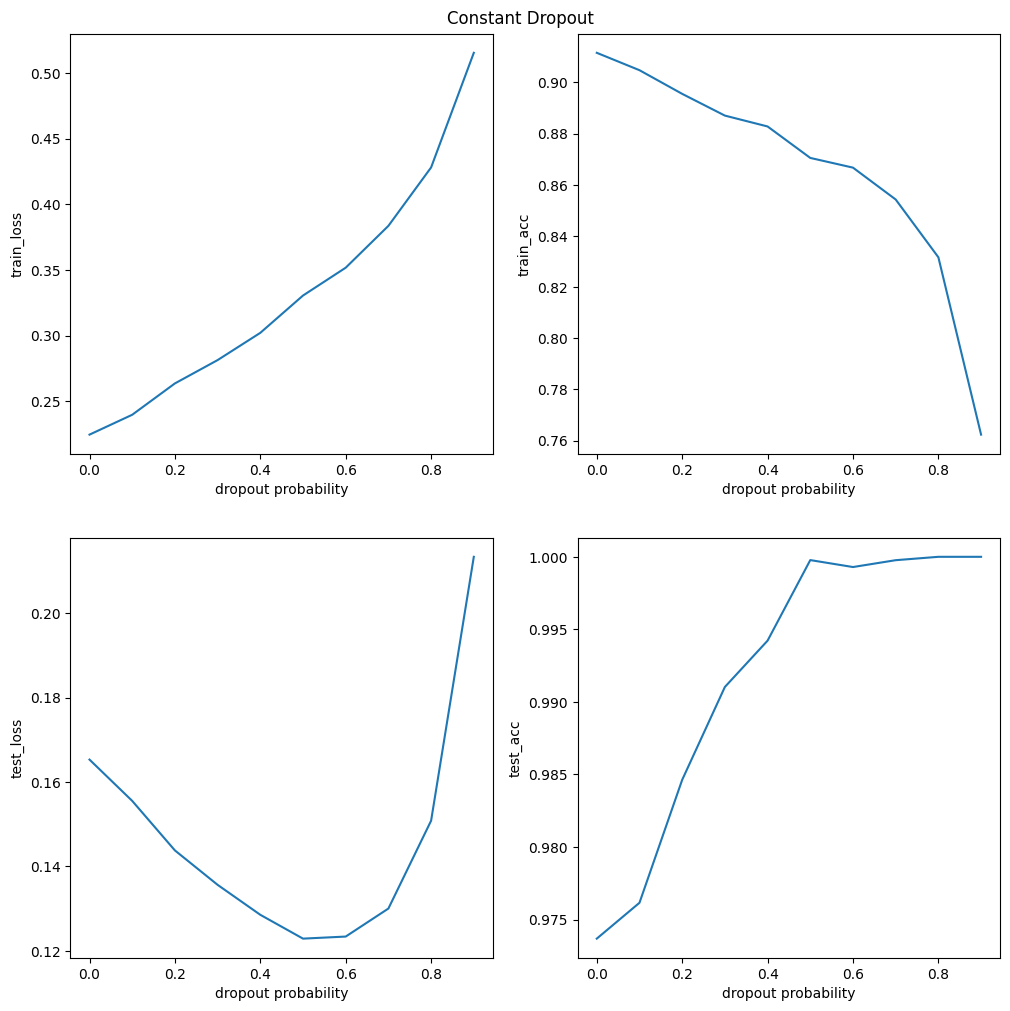

In [321]:
plt.figure(figsize=(12, 12))
for j, key in enumerate(const_aug[0.0][0].keys()):
    plt.subplot(2,2,j+1)
    vals = []
    for k in const_aug.keys():
        vals.append(np.mean([i[key][-1] for i in const_aug[k]]))
    plt.plot(np.arange(0, 1, 0.1), vals)
    plt.xlabel("dropout probability")
    plt.ylabel(key)
plt.suptitle("Constant Dropout", y=0.90)
plt.show()

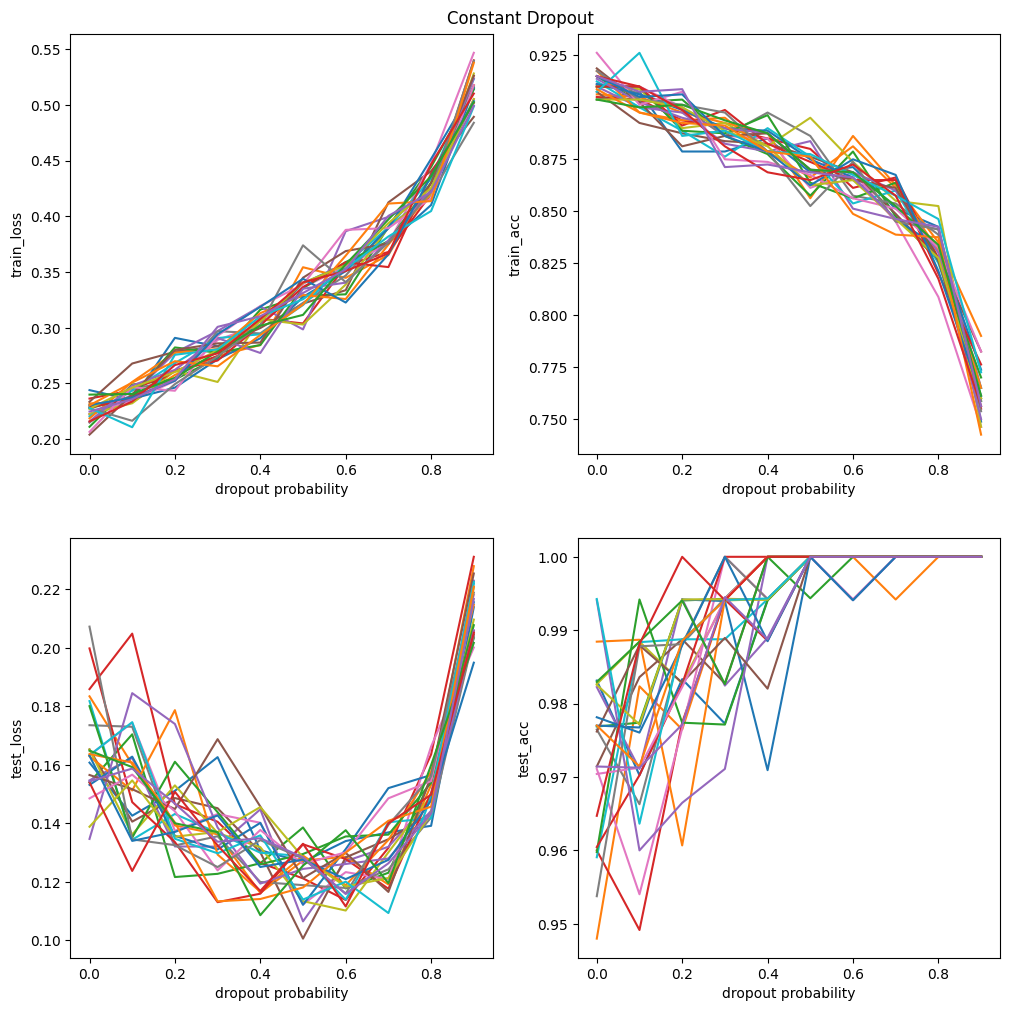

In [322]:
plt.figure(figsize=(12, 12))
for j, key in enumerate(const_aug[0.0][0].keys()):
    plt.subplot(2,2,j+1)
    vals = []
    means = []
    for k in const_aug.keys():
        vals.append([i[key][-1] for i in const_aug[k]])
        means.append(np.mean([i[key][-1] for i in const_aug[k]]))
    plt.plot(np.arange(0, 1, 0.1), vals)
    # plt.plot(np.arange(0, 1, 0.1), means)
    plt.xlabel("dropout probability")
    plt.ylabel(key)
plt.suptitle("Constant Dropout", y=0.90)
plt.show()

### Train w/ Uniform Dropout

In [323]:
uniform_aug = {}
for d in np.arange(0, 1.0, 0.1):
    uniform_aug[d] = []
    for i in range(PARAMS.avg):
        dataset._shuffle()
        for params in PARAMS:
            transforms = UniformDropout(d)
            model = NonlinearModel(
                    in_dim=params.d,
                    hidden_dim=params.m,
                    out_dim=1,
                    init_var=params.init_var,
            )
            model.to(device)
            m, h = trainer.train(model, dataset, transforms, params.epochs,
                                 params.lr, device, test_all=params.test_all,
                                 leave=False)
        uniform_aug[d].append(h)

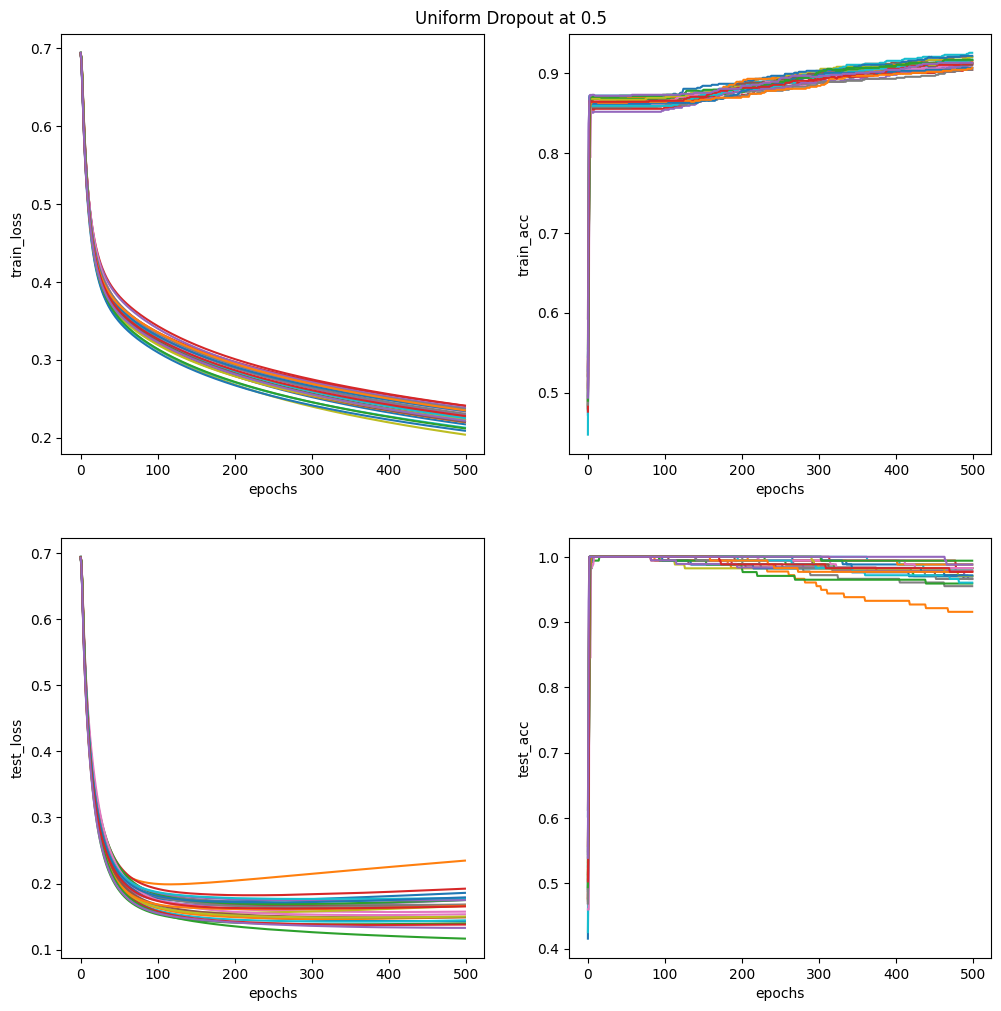

In [324]:
plt.figure(figsize=(12,12))
for j, key in enumerate(uniform_aug[0.0][0].keys()):
    for i in uniform_aug[0]:
        plt.subplot(2,2,j+1)
        plt.plot(i[key])
        plt.xlabel("epochs")
        plt.ylabel(key)
plt.suptitle("Uniform Dropout at 0.5", y=0.90)
plt.show()

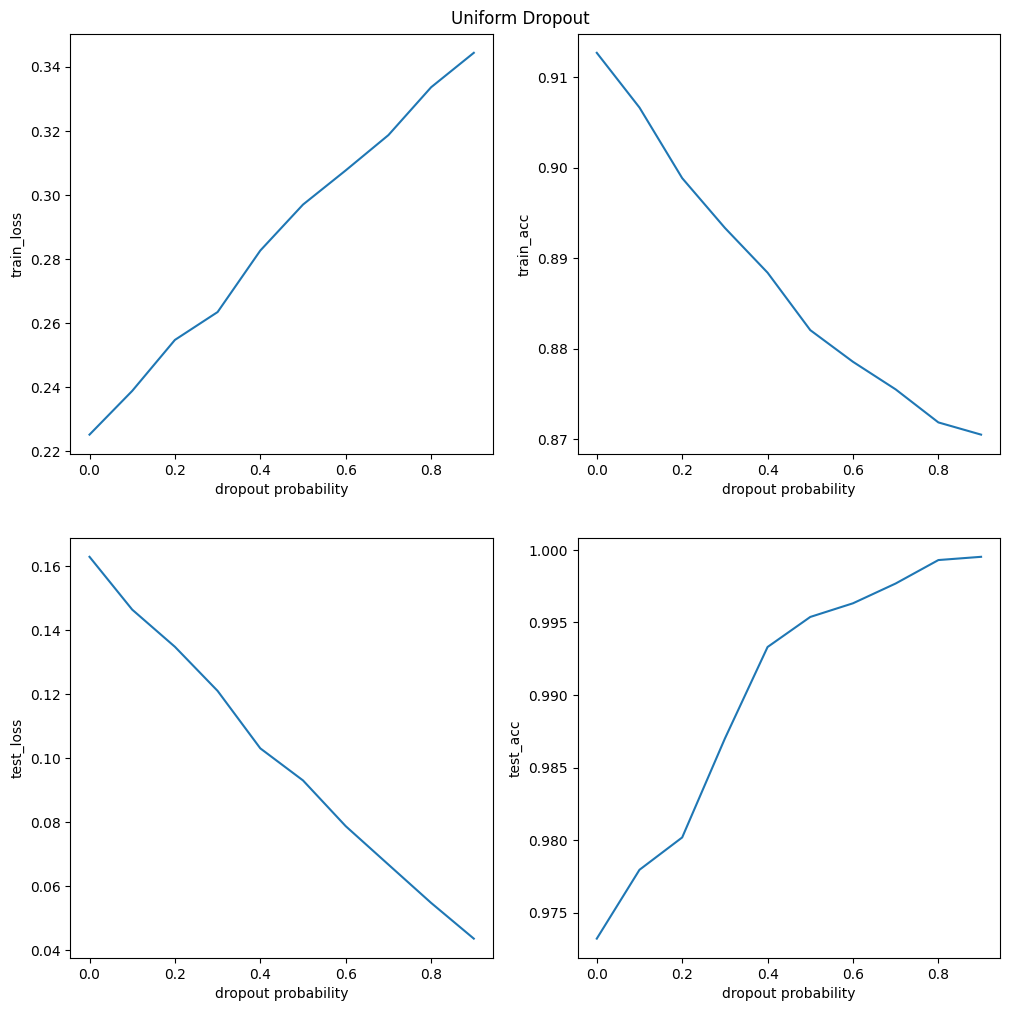

In [325]:
plt.figure(figsize=(12, 12))
for j, key in enumerate(uniform_aug[0.0][0].keys()):
    plt.subplot(2,2,j+1)
    vals = []
    for k in uniform_aug.keys():
        vals.append(np.mean([i[key][-1] for i in uniform_aug[k]]))
    plt.plot(np.arange(0, 1, 0.1), vals)
    plt.xlabel("dropout probability")
    plt.ylabel(key)
plt.suptitle("Uniform Dropout", y=0.90)
plt.show()

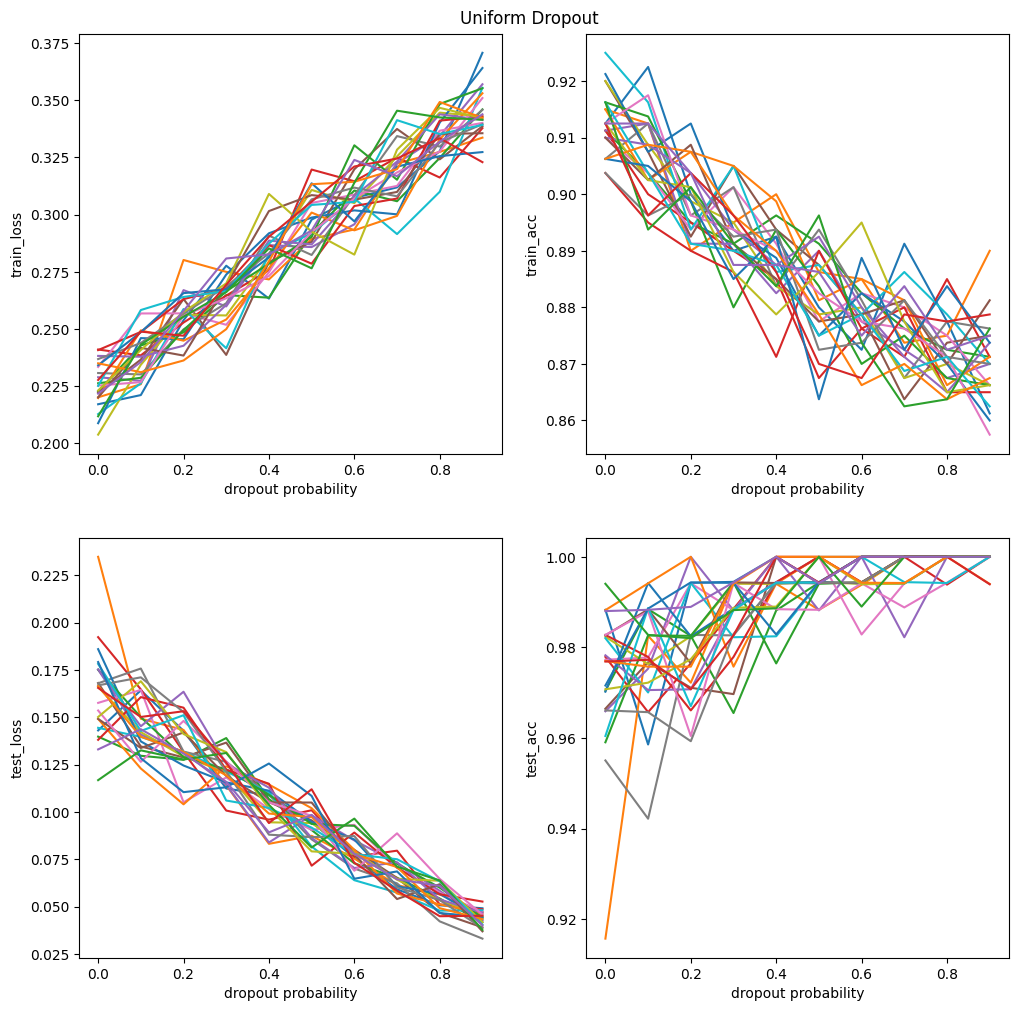

In [326]:
plt.figure(figsize=(12, 12))
for j, key in enumerate(uniform_aug[0.0][0].keys()):
    plt.subplot(2,2,j+1)
    vals = []
    means = []
    for k in uniform_aug.keys():
        vals.append([i[key][-1] for i in uniform_aug[k]])
        means.append(np.mean([i[key][-1] for i in uniform_aug[k]]))
    plt.plot(np.arange(0, 1, 0.1), vals)
    # plt.plot(np.arange(0, 1, 0.1), means)
    plt.xlabel("dropout probability")
    plt.ylabel(key)
plt.suptitle("Uniform Dropout", y=0.90)
plt.show()

### Train w/ Variance Dropout

In [205]:
# p = torch.softmax(torch.Tensor(params['cluster_var']), dim=0)
# p = 1 - torch.tanh(torch.Tensor(params['cluster_var']))
p = (1 - torch.tensor(params['cluster_var']))
print(p)

tensor([0.5000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000], dtype=torch.float64)


In [206]:
var_aug = {}
for d in np.arange(1, 10, 1):
    var_aug[d] = []
    # for i in range(PARAMS.avg):
    for i in range(100):
        dataset._shuffle()
        for params in PARAMS:
            transforms = EntrywiseDropout(p / d)
            model = NonlinearModel(
                    in_dim=params.d,
                    hidden_dim=params.m,
                    out_dim=1,
                    init_var=params.init_var,
            )
            model.to(device)
            m, h = trainer.train(model, dataset, transforms, params.epochs,
                                 params.lr, device, test_all=params.test_all,
                                 leave=False)
        var_aug[d].append(h)

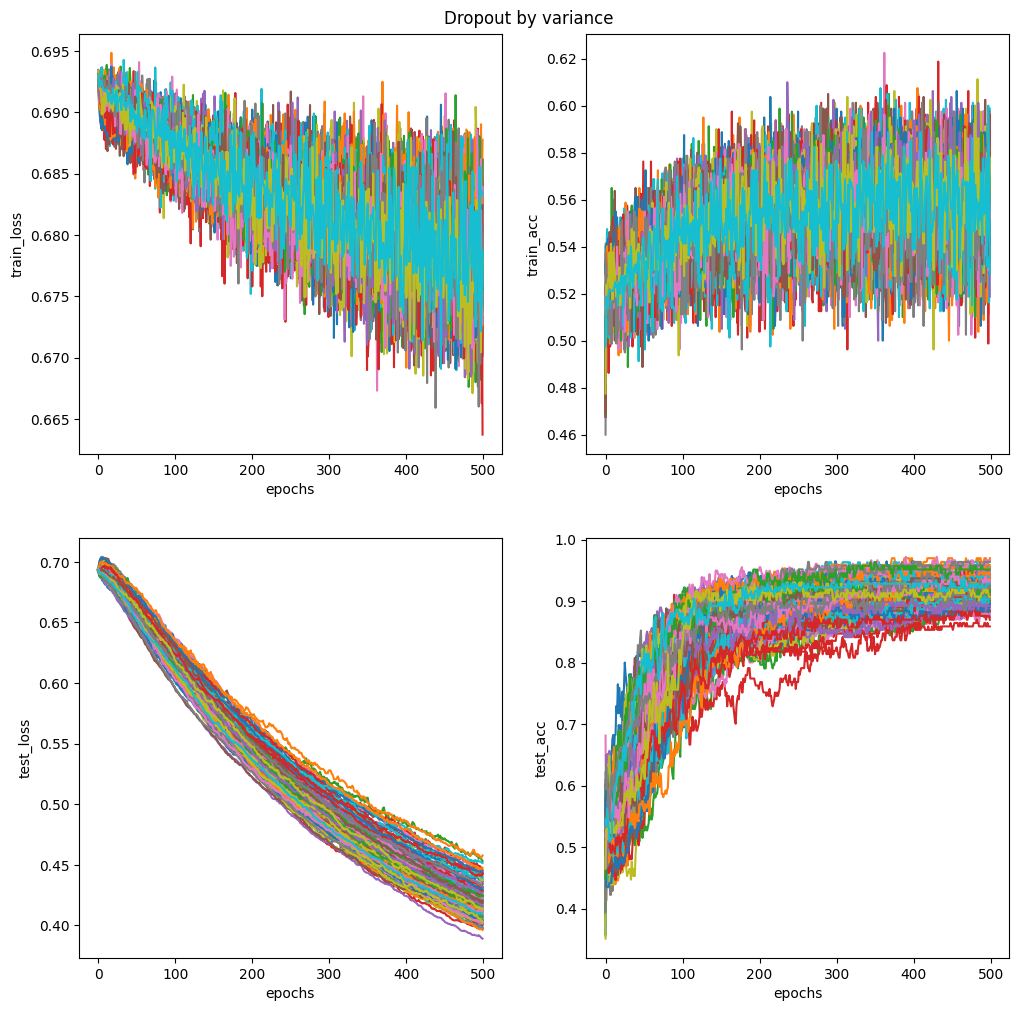

In [207]:
num = 1
plt.figure(figsize=(12,12))
for j, key in enumerate(var_aug[num][0].keys()):
    for i in var_aug[num]:
        plt.subplot(2,2,j+1)
        plt.plot(i[key])
        plt.xlabel("epochs")
        plt.ylabel(key)
plt.suptitle("Dropout by variance", y=0.90)
plt.show()

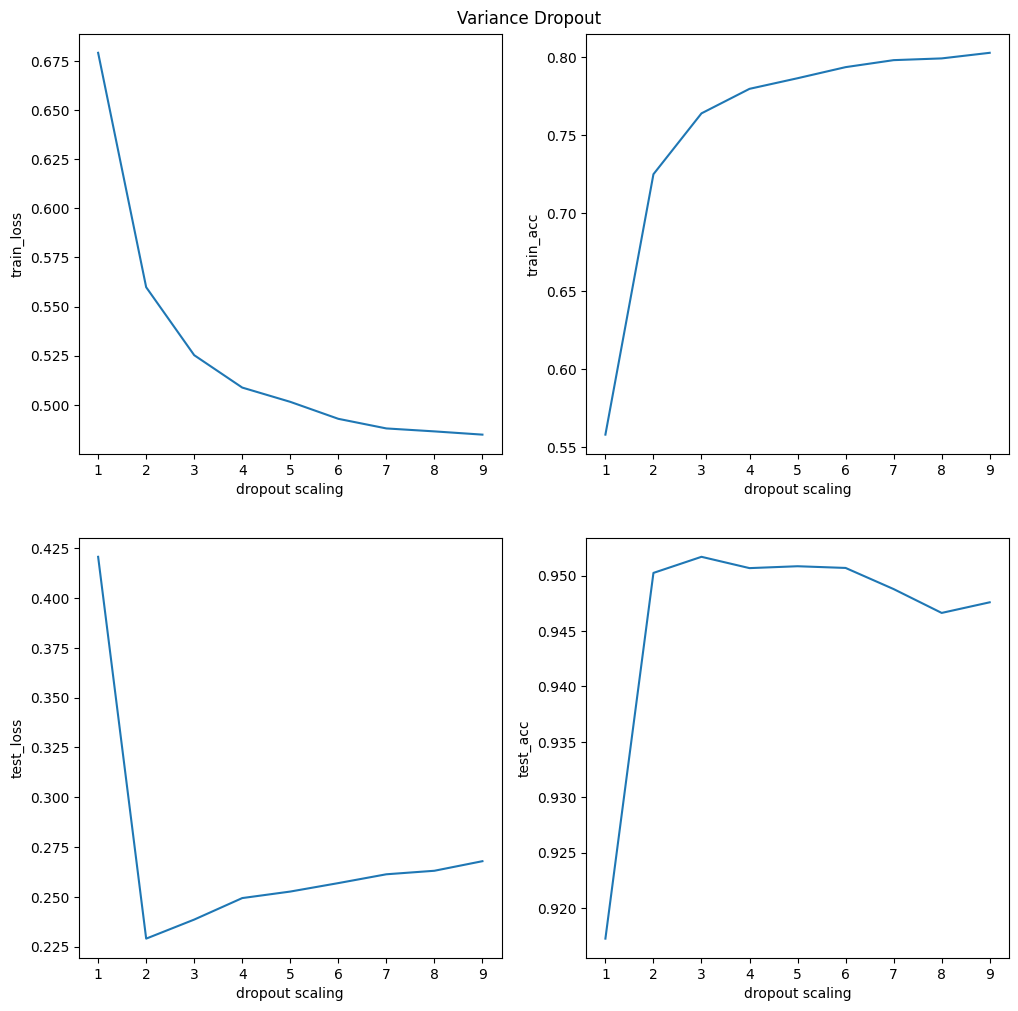

In [208]:
plt.figure(figsize=(12, 12))
for j, key in enumerate(var_aug[1][0].keys()):
    plt.subplot(2,2,j+1)
    vals = []
    for k in var_aug.keys():
        vals.append(np.mean([i[key][-1] for i in var_aug[k]]))
    plt.plot(np.arange(1, 10, 1), vals)
    plt.xlabel("dropout scaling")
    plt.ylabel(key)
plt.suptitle("Variance Dropout", y=0.90)
plt.show()

### Train w/ Inv. Variance Aug

In [117]:
q = F.softmax(torch.Tensor(1/params['cluster_var']), dim=0)
print(np.around(q, decimals=4))

tensor([0.0000, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
        0.1111])


### Compare augmentation types

In [144]:
train_loss_noaug = [h['train_loss'][-1].item() for h in no_aug]
train_acc_noaug = [h['train_acc'][-1].item() for h in no_aug]
test_loss_noaug = [h['test_loss'][-1].item() for h in no_aug]
test_acc_noaug = [h['test_acc'][-1].item() for h in no_aug]

In [275]:
print(f"train loss (no aug):\t {np.mean(train_loss_noaug):.8f}")
print(f"train acc (no aug):\t {np.mean(train_acc_noaug):.8f}")
print(f"test loss (no aug):\t {np.mean(test_loss_noaug):.8f}")
print(f"test acc (no aug):\t {np.mean(test_acc_noaug):.8f}")

train loss (no aug):	 0.46746327
train acc (no aug):	 0.81585000
test loss (no aug):	 0.27738885
test acc (no aug):	 0.94299116


In [146]:
# train_loss_constaug = [h['train_loss'][-1].item() for h in const_aug]
# train_acc_constaug = [h['train_acc'][-1].item() for h in const_aug]
# test_loss_constaug = [h['test_loss'][-1].item() for h in const_aug]
# test_acc_constaug = [h['test_acc'][-1].item() for h in const_aug]

In [147]:
# print(f"train loss (const aug):\t {np.mean(train_loss_constaug):.4f}")
# print(f"train acc (const aug):\t {np.mean(train_acc_constaug):.4f}")
# print(f"test loss (const aug):\t {np.mean(test_loss_constaug):.4f}")
# print(f"test acc (const aug):\t {np.mean(test_acc_constaug):.4f}")

In [ ]:
train_loss_varaug = [h['train_loss'][-1].item() for h in var_aug]
train_acc_varaug = [h['train_acc'][-1].item() for h in var_aug]
test_loss_varaug = [h['test_loss'][-1].item() for h in var_aug]
test_acc_varaug = [h['test_acc'][-1].item() for h in var_aug]

In [213]:
print(f"train loss (var aug):\t {np.mean(train_loss_varaug):.4f}")
print(f"train acc (var aug):\t {np.mean(train_acc_varaug):.4f}")
print(f"test loss (var aug):\t {np.mean(test_loss_varaug):.4f}")
print(f"test acc (var aug):\t {np.mean(test_acc_varaug):.4f}")

train loss (var aug):	 0.6700
train acc (var aug):	 0.5717
test loss (var aug):	 0.4197
test acc (var aug):	 0.9169


In [238]:
var_aug_mean = {}
for k in var_aug.keys():
    var_aug_mean[k] = {
        'train_loss': 0,
        'train_acc': 0,
        'test_loss': 0,
        'test_acc': 0,
    }
    var_aug_mean[k]['train_loss'] = np.mean([h['train_loss'][-1].item() for h in var_aug[k]])
    var_aug_mean[k]['train_acc'] = np.mean([h['train_acc'][-1].item() for h in var_aug[k]])
    var_aug_mean[k]['test_loss'] = np.mean([h['test_loss'][-1].item() for h in var_aug[k]])
    var_aug_mean[k]['test_acc'] = np.mean([h['test_acc'][-1].item() for h in var_aug[k]])

In [240]:
v_df = pd.DataFrame.from_dict(var_aug_mean)
v_df

,1,2,3,4,5,6,7,8,9
train_loss,0.679088,0.559835,0.525254,0.508776,0.501514,0.492881,0.487990,0.486488,0.484837
train_acc,0.557937,0.724925,0.763950,0.779675,0.786475,0.793587,0.798075,0.799188,0.802775
test_loss,0.420624,0.229006,0.238567,0.249360,0.252631,0.256873,0.261300,0.263065,0.267870
test_acc,0.917227,0.950242,0.951695,0.950675,0.950845,0.950691,0.948783,0.946630,0.947589


In [235]:
import pandas as pd
c = ['red', 'orange', 'olive', 'green', 'blue', 'purple']

In [152]:
const_aug_mean = {}
for k in const_aug.keys():
    const_aug_mean[k] = {
        'train_loss': 0,
        'train_acc': 0,
        'test_loss': 0,
        'test_acc': 0,
    }
    const_aug_mean[k]['train_loss'] = np.mean([h['train_loss'][-1].item() for h in const_aug[k]])
    const_aug_mean[k]['train_acc'] = np.mean([h['train_acc'][-1].item() for h in const_aug[k]])
    const_aug_mean[k]['test_loss'] = np.mean([h['test_loss'][-1].item() for h in const_aug[k]])
    const_aug_mean[k]['test_acc'] = np.mean([h['test_acc'][-1].item() for h in const_aug[k]])

In [153]:
const_aug_df = pd.DataFrame.from_dict(const_aug_mean)
const_aug_df

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
train_loss,0.467703,0.484679,0.502282,0.522605,0.548187,0.569829,0.595500,0.621063,0.653506,0.678602
train_acc,0.815200,0.802850,0.783150,0.761600,0.737600,0.706650,0.680500,0.643600,0.602800,0.554450
test_loss,0.276036,0.286011,0.297927,0.314028,0.329909,0.361037,0.406622,0.461125,0.550891,0.657009
test_acc,0.941686,0.943855,0.947170,0.949009,0.956186,0.950369,0.942312,0.935024,0.894707,0.674588


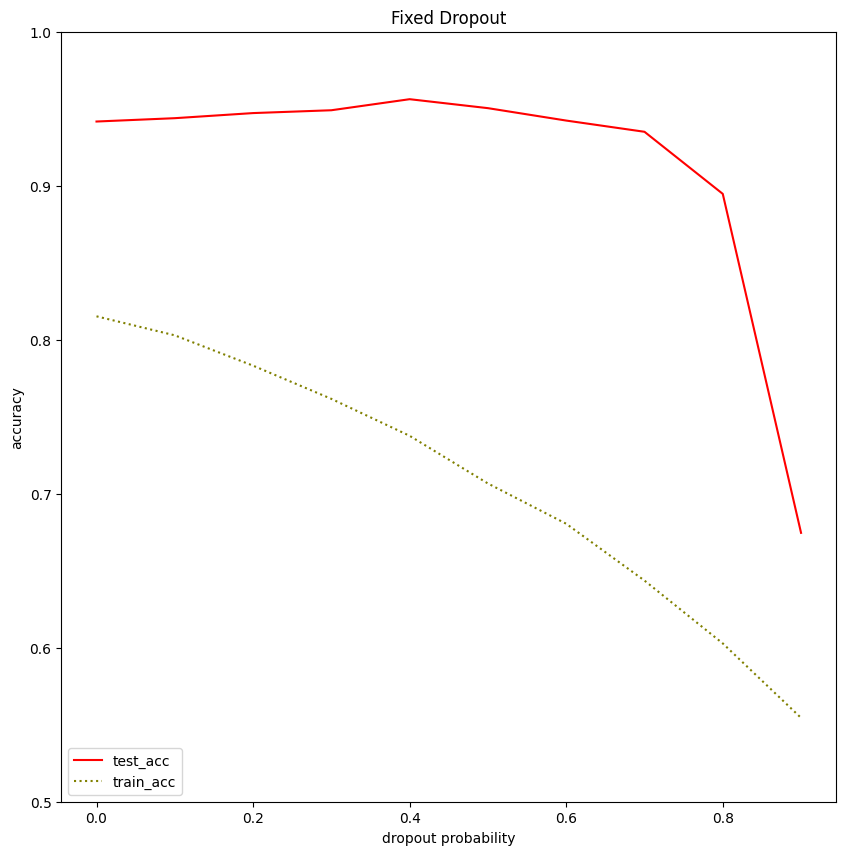

In [204]:
x = list(map(float, const_aug_df.columns.to_list()))
plt.figure(figsize=(10, 10))
for i, k in enumerate(sorted(const_aug_df.index)):
    if k.endswith('acc'):
        style = ':' if k.startswith('train') else '-'
        plt.plot(x, const_aug_df.loc[k].to_list(), label=k, linestyle=style, color=c[i])
# for i, k in enumerate(sorted(v_df.index)):
#     if k.endswith('acc'):
#         style = ':' if k.endswith('train') else '-'
#         plt.scatter([0], v_df.loc[k].to_list(), color=c[i])
plt.ylim(0.5, 1.0)
plt.xlabel('dropout probability')
plt.ylabel('accuracy')
plt.title('Fixed Dropout')
plt.legend(loc='lower left')
plt.show()

In [129]:
uniform_aug_mean = {}
for k in uniform_aug.keys():
    uniform_aug_mean[k] = {
        'train_loss': 0,
        'train_acc': 0,
        'test_loss': 0,
        'test_acc': 0,
    }
    uniform_aug_mean[k]['train_loss'] = np.mean([h['train_loss'][-1].item() for h in uniform_aug[k]])
    uniform_aug_mean[k]['train_acc'] = np.mean([h['train_acc'][-1].item() for h in uniform_aug[k]])
    uniform_aug_mean[k]['test_loss'] = np.mean([h['test_loss'][-1].item() for h in uniform_aug[k]])
    uniform_aug_mean[k]['test_acc'] = np.mean([h['test_acc'][-1].item() for h in uniform_aug[k]])

In [130]:
uniform_aug_df = pd.DataFrame.from_dict(uniform_aug_mean)
uniform_aug_df

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
train_loss,0.466965,0.474111,0.484783,0.494200,0.506391,0.512156,0.526302,0.536425,0.550506,0.563885
train_acc,0.815700,0.808900,0.801400,0.793200,0.785050,0.774500,0.764100,0.751100,0.737400,0.725700
test_loss,0.283282,0.266395,0.255904,0.257654,0.256320,0.245993,0.241188,0.238054,0.232219,0.231423
test_acc,0.935797,0.954674,0.952798,0.951226,0.945227,0.951552,0.949155,0.947448,0.954279,0.950631


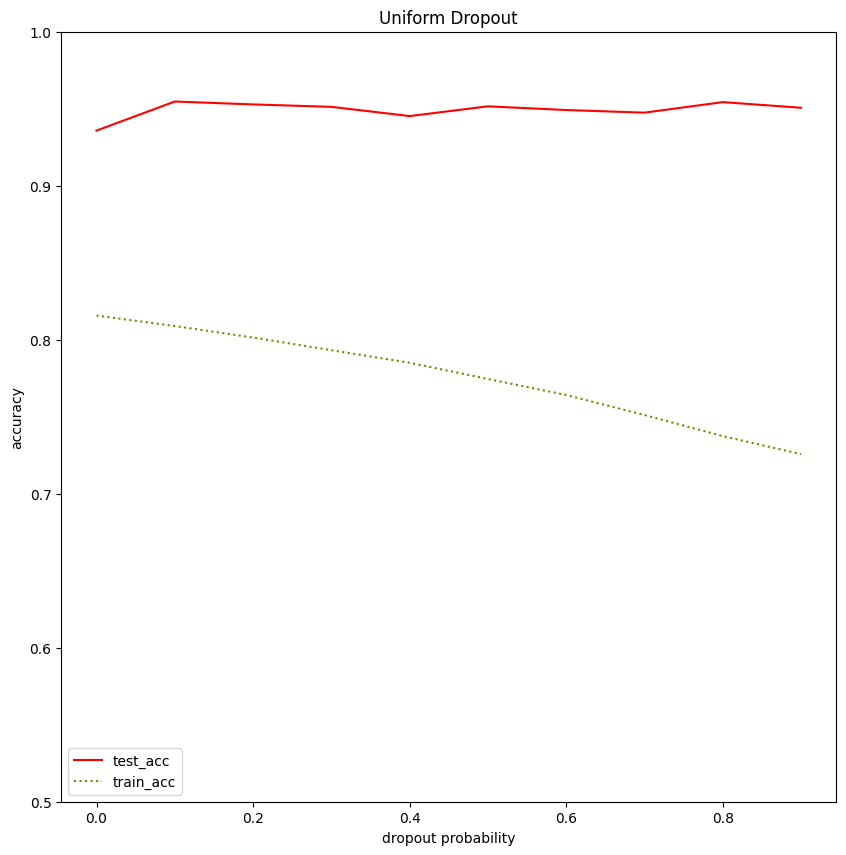

In [211]:
x = list(map(float, uniform_aug_df.columns.to_list()))
plt.figure(figsize=(10, 10))
for i, k in enumerate(sorted(uniform_aug_df.index)):
    if k.endswith('acc'):
        style = ':' if k.startswith('train') else '-'
        plt.plot(x, uniform_aug_df.loc[k].to_list(), label=k, linestyle=style, color=c[i])
# for i, k in enumerate(sorted(v_df.index)):
#     if k.endswith('acc'):
#         style = ':' if k.endswith('train') else '-'
#         plt.scatter([0], v_df.loc[k].to_list(), color=c[i])
plt.ylim(0.5, 1.0)
plt.xlabel('dropout probability')
plt.ylabel('accuracy')
plt.title('Uniform Dropout')
plt.legend(loc='lower left')
plt.show()

In [274]:
uniform_aug_df.loc['test_acc'].max() * 100

95.46744894981384

In [269]:
v_df

,1,2,3,4,5,6,7,8,9
train_loss,0.679088,0.559835,0.525254,0.508776,0.501514,0.492881,0.487990,0.486488,0.484837
train_acc,0.557937,0.724925,0.763950,0.779675,0.786475,0.793587,0.798075,0.799188,0.802775
test_loss,0.420624,0.229006,0.238567,0.249360,0.252631,0.256873,0.261300,0.263065,0.267870
test_acc,0.917227,0.950242,0.951695,0.950675,0.950845,0.950691,0.948783,0.946630,0.947589


## Leverage experiments

In [59]:
A = dataset.x

In [60]:
F.softmax(A.var(axis=0), dim=0)

tensor([0.1518, 0.0963, 0.0931, 0.0962, 0.0890, 0.0946, 0.0929, 0.0862, 0.0938,
        0.1060])

In [61]:
# Compute pi probability distribution according to CUR paper
k = 1
U, S, Vh = torch.linalg.svd(A)
pi = torch.sum(Vh[:, :k]**2, dim=1) / k
print(pi)

tensor([7.0189e-01, 8.8338e-03, 2.8873e-01, 4.1946e-07, 1.5619e-04, 9.4353e-10,
        7.1504e-06, 7.7483e-07, 2.6732e-04, 1.1433e-04])


In [62]:
A0 = (A - A.mean(axis=0)[np.newaxis, :])
cov_A = (A0.T @ A0) / (A0.shape[0] - 1)
torch.diag(cov_A)

tensor([0.6696, 0.2150, 0.1812, 0.2136, 0.1361, 0.1973, 0.1787, 0.1041, 0.1879,
        0.3105])

In [63]:
lev_aug = []
for i in range(PARAMS.avg):
    dataset._shuffle()
    for params in PARAMS:
        transforms = EntrywiseDropout(pi)
        model = NonlinearModel(
                in_dim=params.d,
                hidden_dim=params.m,
                out_dim=1,
                init_var=params.init_var,
        )
        model.to(device)
        m, h = trainer.train(model, dataset, transforms, params.epochs,
                             params.lr, device, test_all=params.test_all,
                             leave=False)
    lev_aug.append(h)

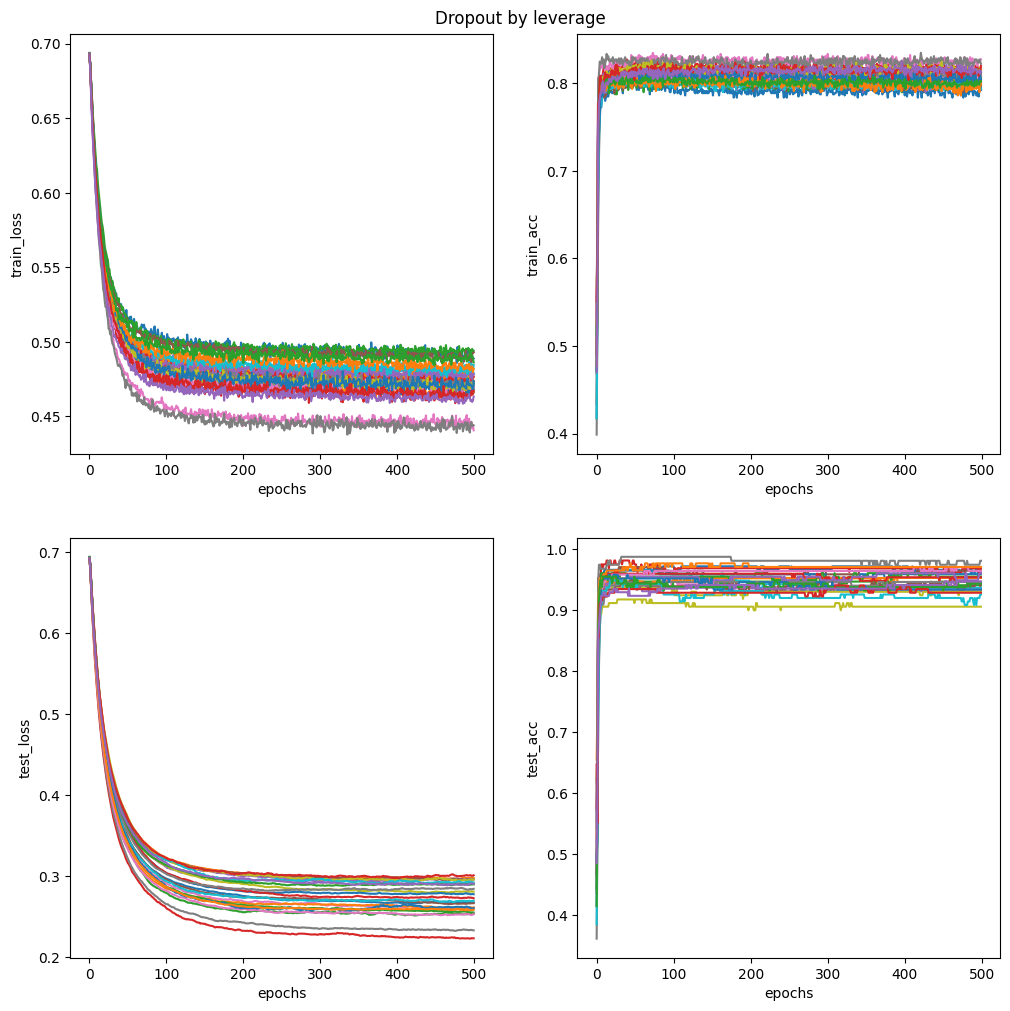

In [64]:
plt.figure(figsize=(12,12))
for j, key in enumerate(lev_aug[0].keys()):
    for i in lev_aug:
        plt.subplot(2,2,j+1)
        plt.plot(i[key])
        plt.xlabel("epochs")
        plt.ylabel(key)
plt.suptitle("Dropout by leverage", y=0.90)
plt.show()

In [96]:
train_loss_lev = [h['train_loss'][-1].item() for h in lev_aug]
train_acc_lev = [h['train_acc'][-1].item() for h in lev_aug]
test_loss_lev = [h['test_loss'][-1].item() for h in lev_aug]
test_acc_lev = [h['test_acc'][-1].item() for h in lev_aug]

In [97]:
print(f"train loss (lev aug):\t {np.mean(train_loss_lev):.4f}")
print(f"train acc (lev aug):\t {np.mean(train_acc_lev):.4f}")
print(f"test loss (lev aug):\t {np.mean(test_loss_lev):.4f}")
print(f"test acc (lev aug):\t {np.mean(test_acc_lev):.4f}")

train loss (lev aug):	 0.4733
train acc (lev aug):	 0.8071
test loss (lev aug):	 0.2732
test acc (lev aug):	 0.9471
